# DiffProg example with Inviscid burgers



In [1]:
using Flux, Zygote, Optim, DiffEqFlux, OrdinaryDiffEq, BlockArrays, LinearAlgebra
using Optimization
using OptimizationPolyalgorithms
using Zygote
using OptimizationOptimJL
using OptimizationOptimisers
using DiffEqSensitivity
using DelimitedFiles
using HDF5
using Plots
using InvertedIndices
using SparseArrays, Plots, Random, CUDA
CUDA.allowscalar(false)

## Define the problem
n = 64 # number of grid points
L = 2.0 # length of domain
dt = 0.01 # time step delta
nt = 50 # number of time steps
T = dt*nt # total time
dx = L/n #create grid
xgrid = collect(0:dx:L-dx) #create spatial grid
tsteps = 0:dt:T #create time vector

nsamples = 50
println("Load training data")
using JLD2: @load
@load "/Users/arvindm/work/PROJECTS/BloodFlowDiffProg/mutating_arrays_BCs/inviscidburgersdata.jld2" datasets
traindata = datasets[1:nsamples,:,:]
println("Loaded datasets from inviscidburgersdata.jld2 of size: ", size(traindata))
trainsample  = traindata[1,:,1:nt+1]; #training sample
# dataloader
x = []
y = []
for i=1:nsamples
    push!(x, traindata[i,:,1:end-1])
    push!(y, traindata[i,:,2:end])
end
x = hcat(x...);
y = hcat(y...);
#train_dataloader = Flux.DataLoader((x[:,1:5],y[:,1:5]), batchsize=1, shuffle=false)

function get_fd_operators(n, dx)
    # upwind scheme
    ∂x1 = (diagm(0 => ones(n), -1 => -ones(n-1)))./dx
    ∂x2 = (diagm(0 => -ones(n), 1 => ones(n-1)))./dx
    # boundary conditions
    ∂x1[1,end] = -1/dx
    ∂x2[end,1] = 1/dx
    # ∂x1 = sparse(∂x1)
    # ∂x2 = sparse(∂x2)
    return ∂x1, ∂x2
end

function eqn_dp_inviscidBurgers(u,p,t)
    w = p;
    - 0.5 .* (w + abs.(w)) .* (∂x1*u) - 0.5 .* (w - abs.(w)) .* (∂x2*u) 
end

Random.seed!(1234)
p = ones(n) + 0.01*randn(n); # THIS IS A GLOBAL VAR IN MEMORY!
p_init = deepcopy(p)
println("defined param p is: ", p_init)

#get tridiagonal system for each operator
∂x1, ∂x2 = get_fd_operators(n, dx);

#initial condition
u0 = sin.(π*xgrid); #+ 0.05*randn(n);

#nn_prob = ODEProblem(eqn_dp_inviscidBurgers!, u0, tspan);
nn_prob(u0,tspan) = ODEProblem(eqn_dp_inviscidBurgers, u0, tspan, p);

#Get initial solution
tspan = (0.0, T)
print("Solving DiffProg problem")
sol_initguess = Array(solve(nn_prob(u0,tspan), Tsit5(), saveat=tsteps));
#plot(traindata[10,:,end], label = "Training data")
plot(xgrid/L, u0, label = "NN Initial condition", xlabel = "x", ylabel = "u")
plot!(xgrid/L, sol_initguess[:,end], marker =:star, label = "NN solution")
plot!(xgrid/L, trainsample[:,end], label = "training data")
savefig("invburg_untrainv.png")

Load training data


Loaded datasets from inviscidburgersdata.jld2 of size: (50, 64, 51)
defined param p is: 

[1.0097065632885522, 0.990207815884648, 1.009018608835941, 0.9996719687075536, 0.9939920777664444, 0.9855482288471377, 1.0270742394171577, 1.015244478634356, 1.0075980402000746, 0.9911856309380351, 1.0070599313378261, 1.010915552820534, 1.008714978528809, 1.0008569110900638, 1.0096007915148755, 1.009078369989365, 0.9853493813043094, 0.9978414072621197, 1.0057509444925838, 0.9820436984078718, 0.9894350147618375, 1.0014836063583705, 0.9816148982871579, 0.9892636751425982, 1.0092176615459993, 0.9807813781208673, 1.002338792728477, 1.0040591241315167, 0.9990412158932208, 1.015439016235414, 1.0001101291451278, 0.9909645851677182, 1.0040070351919377, 1.00305846884895, 0.9874710419075431, 0.990576205132169, 0.9954216882437602, 0.99760357602993, 0.9874629069341682, 0.9924651726339675, 1.0012820429210556, 0.9874524848985397, 0.9969118908250396, 1.0013341982262682, 0.9909156360532523, 1.0165283276801287, 1.0106254513760051, 0.9908413837862509, 0.999504586859325, 1.0146823594382115, 0.99782828246

"/Users/arvindm/work/PROJECTS/BloodFlowDiffProg/mutating_arrays_BCs/invburg_untrainv.png"

┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6


┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please

┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please

┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please

┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please

Epoch loss is: 0.00014537008
sum(p) after 

0.05705476243752958


┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6


┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please

┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please

┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please

Epoch loss is: 7.857197e-5
sum(p) after 0.10749270868345664


┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please

┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please

┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please

┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please

┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please

Epoch loss is: 1.5815582e-5
sum(p) after -0.14133173639076163


┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please

┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please

┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please

┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please

Epoch loss is: 3.9357852e-5
sum(p) after -0.004299327778898868


┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please

┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please

┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please

┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please

Epoch loss is: 2.4645702e-5
sum(p) after -0.19975544537805473


┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please

┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6


┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please

┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please

┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please

┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6


Epoch loss is: 2.6537313e-5
sum(p) after 0.1730277065387794


┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please

┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please

┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please

┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please

Epoch loss is: 0.00014999021
sum(p) after 0.007120972187892205


┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please

┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6


┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please

┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please

┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please

Epoch loss is: 2.8683991e-5
sum(p) after 0.16466089115397198


┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please

┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please

┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6


┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please

Epoch loss is: 2.1526852e-5
sum(p) after 0.10917341854666002


┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please

┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please

┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please

┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please

┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /Users/arvindm/.julia/packages/DiffEqFlux/jHIee/src/train.jl:6
┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please

Epoch loss is: 0.00028308798
sum(p) after 0.004369103334783492


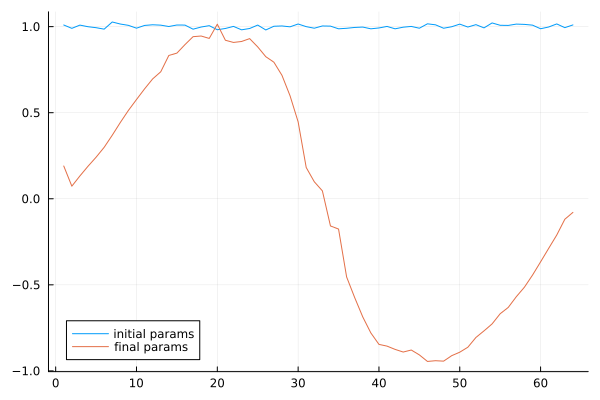

In [2]:
nepochs = 10
nsamples = 20
adtype = Optimization.AutoZygote() ;

losshistory= []
for i=1:nepochs
    global p
    i=1
    for j=1:nsamples
        global res1
        #println("sample: ", i)
        xlocal = x[:,j]; 
        ylocal = y[:,j]; 
        nt = 1
        T = dt*nt # total time
        tspan = (0.0, T)
        tsteps = 0:dt:tspan[2] #create time vector

        function predict_diffprog(p) 
            #println("x predict: ", x)
            #println("sum(p): ", sum(p))
            prob = remake(nn_prob(xlocal,tspan), p=p)
            return Array(solve(prob, Tsit5(), saveat=tsteps))
        end
    
        function loss(p)
            prediction = predict_diffprog(p)
            loss = sum(abs2, prediction[:,end] .- ylocal) + 1e-3*abs.(sum(p)); # L2 norm
            #println("loss is: ", loss)
            return loss, prediction
        end

        # callback = function (θ,l,pred)
        #     global iters += 1 
        #     println("Iteration: $iters || Loss: $l")
        #     flush(stdout)
        #     append!(PRED, [pred])
        #     append!(LOSS, l)
        #     append!(PARS, [θ])     
        #     false
        # end 
        
        #println("sum(p) before ", sum(p))
        res1 = DiffEqFlux.sciml_train(loss, p, ADAM(0.1), maxiters=20)
        #res2 = DiffEqFlux.sciml_train(loss, res1.u, BFGS(), maxiters=30)
        # optf = Optimization.OptimizationFunction((x,p)->loss(x,ylocal,nn_prob),adtype)
        # optprob = Optimization.OptimizationProblem(optf,p);
        # res1 = Optimization.solve(optprob, OptimizationOptimisers.Adam(0.1),callback = callback, maxiters = 30)
        p = res1.minimizer
        #println("sum(p) after ", sum(p))
        
        l = sum((predict_diffprog(p)[:,end] - ylocal).^2);
        push!(losshistory, l)
        i += 1
    end
    println("Epoch loss is: ", losshistory[end])
    println("sum(p) after ", sum(p))
end

plot(p_init, label = "initial params")
plot!(p, label = "final params")

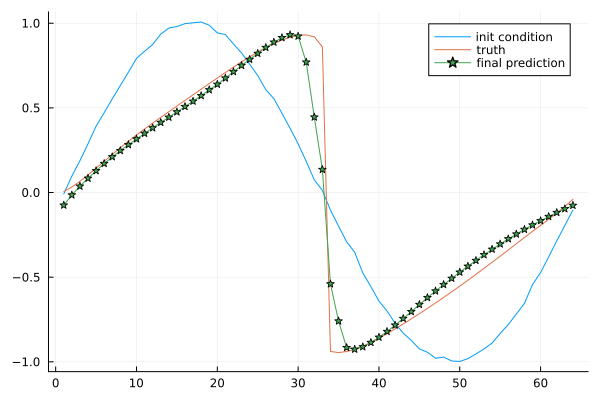

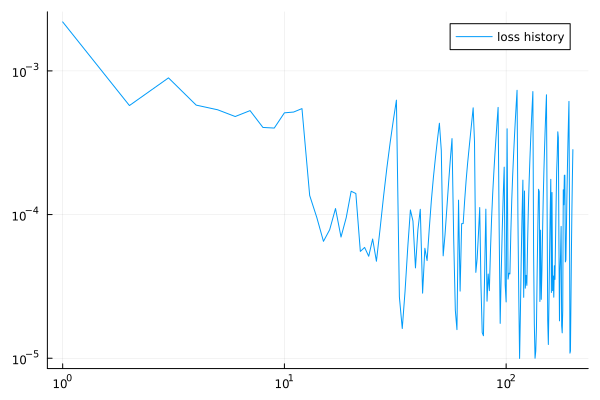

In [3]:
function predict_trained(p,u0,tspan) 
    tsteps = 0:dt:tspan[2]
    prob = remake(nn_prob(u0,tspan), p=p)
    return Array(solve(prob, Tsit5(), saveat=tsteps, reltol = Float32(1e-6)))
end

u0 = sin.(π*xgrid) + 0.01*randn(n);
ytest = y[:,end];
nt = 50 # number of time steps
T = dt*nt # total time
pred = predict_trained(p,u0,(0,T)) #after training
plot(u0, label = "init condition")
plot!(ytest, label = "truth")
display(plot!(pred[:,end], shape = :star, label = "final prediction" ))
display(plot(losshistory, xaxis=:log, yaxis=:log, label = "loss history"))